In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [2]:
data = []
labels = []
file_name = []

# Loop melalui setiap subfolder (normal-cecum, polyps, ulcerative-colitis)
for sub_folder in os.listdir("dataset/"):
    sub_folder_path = os.path.join("dataset/", sub_folder)
    
    # Loop melalui setiap file gambar di subfolder
    for filename in os.listdir(sub_folder_path):
        img_path = os.path.join(sub_folder_path, filename)
        img = cv2.imread(img_path) # Baca gambar
        if img is None:  # Skip jika gambar corrupt
            continue
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (512, 512)) #Resize gambar ke ukuran tetap agar bisa di-convert ke numpy array

        # Simpan ke list
        data.append(img_resized)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

        
data = np.array(data)
labels = np.array(labels)

In [3]:
def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

def median(imageCitra):
    sort_image = sorted(imageCitra.flatten())
    
    if(len(imageCitra.flatten()) % 2 == 0):
        index_median1 = len(imageCitra.flatten())/2 - 1
        index_median2 = len(imageCitra.flatten())/2 
        
        return (sort_image[index_median1] + sort_image[index_median2])/2
    else:
        index_median1 = len(imageCitra.flatten())//2
        
        return (sort_image[index_median1])
    
def filteringCitra(imageCitra, kernel_size, filter):
    citra_height, citra_width = imageCitra.shape
    pad = kernel_size // 2

    padded_image = np.pad(imageCitra, pad_width=pad, mode='edge')

    result = np.zeros((citra_height, citra_width))

    for i in range(citra_height):
        for j in range(citra_width):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            if(filter == "mean"):
                result[i][j] = np.sum(region)/(kernel_size*kernel_size)
            elif(filter == "modus"):
                result[i][j] = modus(region)
            elif(filter == "median"):
                result[i][j] = median(region)
                
    return result

kernel_tajam = np.array([[1/9,1/9,1/9],
                         [1/9,8/9,1/9],
                         [1/9,1/9,1/9]])

def convo(image, kernel):
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height //2
    pad_width = kernel_width //2
    padded_img =  np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='edge')
    result = np.zeros([img_height, img_width])

    for i in range(img_height):
        for j in range(img_width):
            result[i, j] = np.sum(padded_img[i:i+kernel_height, j:j+kernel_width] * kernel)
    return result

def thresholding(imageCitra, threshold, min_val, max_val):
    imageCitra = imageCitra.astype(np.uint8)
    result = np.where(imageCitra <= threshold, max_val, min_val).astype(np.uint8)
    
    return result

def dilasi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.any(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def erosi(gambar, kernel):
    gambar = gambar // 255
    padded = np.pad(gambar, ((kernel.shape[0]//2, kernel.shape[0]//2), (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant', constant_values=0)
    result = np.zeros_like(gambar)
    k_h, k_w = kernel.shape

    for i in range(gambar.shape[0]):
        for j in range(gambar.shape[1]):
            neighborhood = padded[i:i+k_h, j:j+k_w]
            if np.all(neighborhood[kernel==1] == 1):
                result[i, j] = 1
    return (result * 255).astype(np.uint8)

def opening(gambar, kernel):
    eroded = erosi(gambar, kernel)
    opened = dilasi(eroded, kernel)
    return opened.astype(np.uint8)

def closing(gambar, kernel):
    dilated = dilasi(gambar, kernel)
    closed = erosi(dilated, kernel)
    return closed.astype(np.uint8)

def maskerImage(channel, mask_median):
    objek = channel.copy()
    objek[mask_median == 0] = 0 

    return objek

In [4]:
def preprocess_3(img):
    img_equalized = histogram_equalization(img)
    img_median = filteringCitra(img_equalized, kernel_size=3, filter="median")
    img_tresh = thresholding(img_median, 120, 255, 0)
    opened = opening(img_tresh, np.ones((3, 3), dtype=np.uint8))
    closed = closing(opened, np.ones((3, 3), dtype=np.uint8))
    Image_RGB = cv2.resize(closed, (512, 512), interpolation=cv2.INTER_AREA)
    masking = maskerImage(Image_RGB, closed)
    return masking

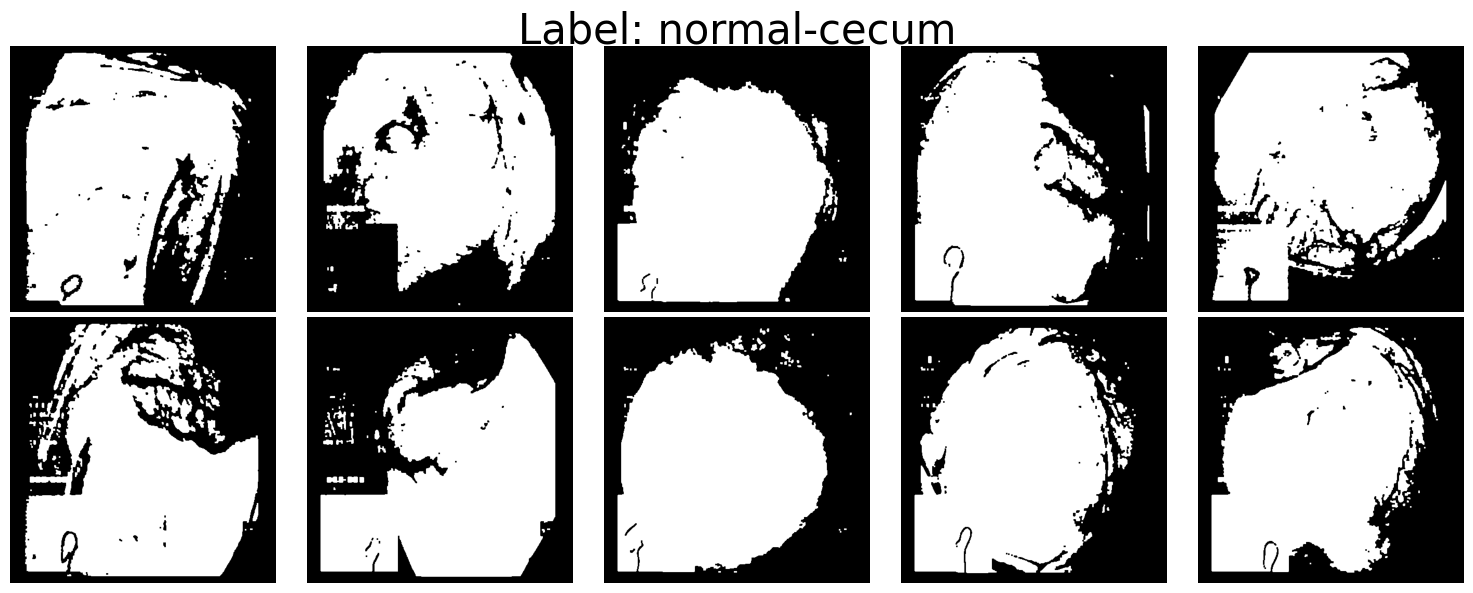

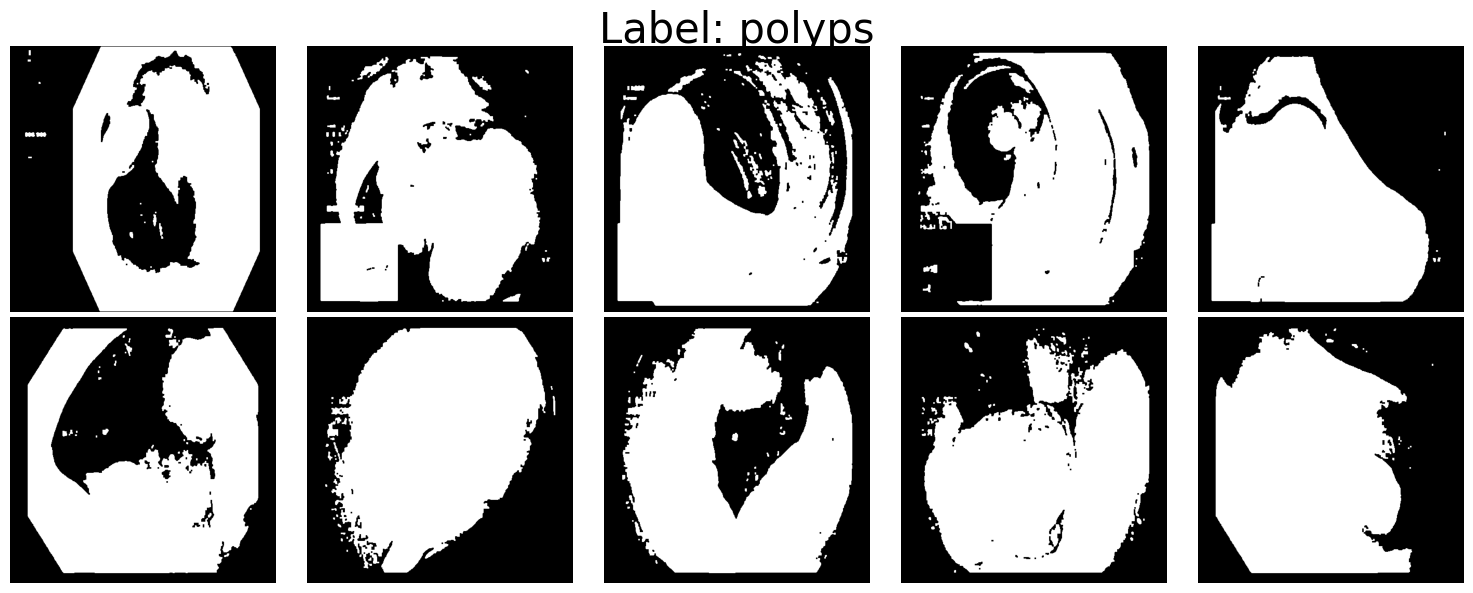

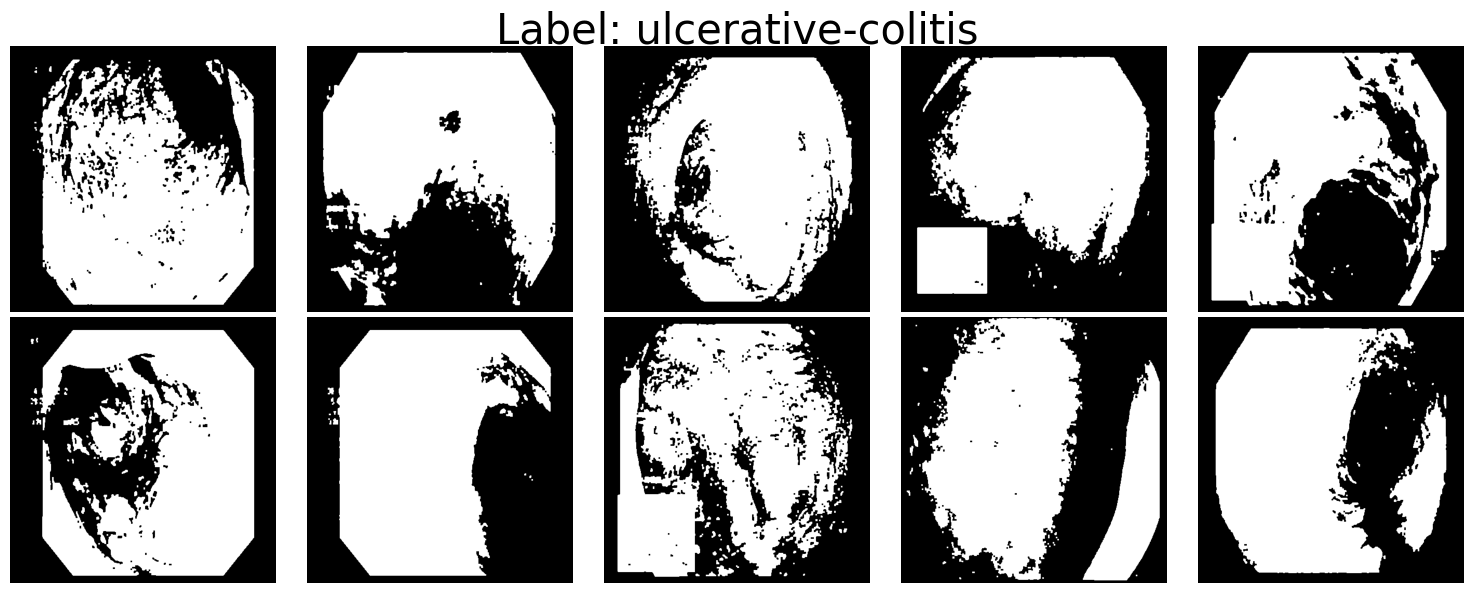

In [5]:
dataPreprocessed3 = [preprocess_3(img) for img in data] 
unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
	
    # Buat grid 10x10 (cukup untuk 100 gambar, 10*10 = 100)
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f'Label: {label}', fontsize=30)
    
    for k in range(min(10, len(idxs))):
        row = k // 5
        col = k % 5
        ax = axs[row][col]
        ax.imshow(dataPreprocessed3[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [6]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [7]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed3)):
    D0 = glcm(dataPreprocessed3[i], 0)
    D45 = glcm(dataPreprocessed3[i], 45)
    D90 = glcm(dataPreprocessed3[i], 90)
    D135 = glcm(dataPreprocessed3[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [8]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [9]:
for i in range(len(dataPreprocessed3)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [10]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [11]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [12]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [13]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [14]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [15]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [16]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_3.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,00f3d2cc-93ea-40f0-9b88-b159b07a49cb.jpg,normal-cecum,896.221219,1429.389057,838.063769,1326.791794,0.986217,0.978018,0.987112,0.979596,...,0.496342,0.489377,0.703897,0.698474,0.704515,0.699555,0.971926,0.955197,0.973747,0.958412
1,01c49663-9674-44ae-b61e-05243a30e4ab.jpg,normal-cecum,847.011069,1278.481432,732.187385,1255.073318,0.986974,0.980339,0.988740,0.980699,...,0.492777,0.485172,0.700752,0.696294,0.701980,0.696543,0.973743,0.960352,0.977302,0.961078
2,01e023db-5c76-4c28-91ab-06e36cd31495.jpg,normal-cecum,460.785951,712.204304,399.646068,688.298145,0.992914,0.989047,0.993854,0.989415,...,0.496061,0.491836,0.703657,0.701054,0.704316,0.701310,0.985766,0.977993,0.987654,0.978732
3,02dcedf1-c0bd-4ef4-b072-ea8f11da6a1d.jpg,normal-cecum,711.807424,1071.792770,631.778796,1080.757580,0.989053,0.983517,0.990284,0.983380,...,0.493210,0.486647,0.701430,0.697697,0.702289,0.697601,0.977982,0.966836,0.980457,0.966559
4,032a3076-c75c-4089-a57c-1b19e5f6589e.jpg,normal-cecum,944.437225,1620.638325,994.144447,1458.773710,0.985476,0.975077,0.984712,0.977566,...,0.501481,0.495029,0.708677,0.701896,0.708153,0.703583,0.969958,0.948403,0.968377,0.953557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,fc79c489-b358-4368-b965-330615af73d4_00000332.jpg,ulcerative-colitis,1499.169826,2197.374397,1241.189342,2172.970194,0.976945,0.966208,0.980912,0.966583,...,0.483524,0.470089,0.692621,0.685375,0.695359,0.685630,0.953681,0.932090,0.961652,0.932844
296,fc79c489-b358-4368-b965-330615af73d4_00000351.jpg,ulcerative-colitis,1568.759938,2320.391504,1311.773598,2283.038132,0.975875,0.964316,0.979827,0.964890,...,0.482795,0.468836,0.692111,0.684326,0.694835,0.684716,0.951501,0.928241,0.959446,0.929396
297,fc79c489-b358-4368-b965-330615af73d4_00000403.jpg,ulcerative-colitis,1707.940160,2474.287399,1369.931048,2414.023958,0.973735,0.961949,0.978933,0.962876,...,0.481279,0.466287,0.690165,0.682224,0.693743,0.682852,0.947267,0.923587,0.957703,0.925448
298,fc79c489-b358-4368-b965-330615af73d4_00000411.jpg,ulcerative-colitis,1395.778804,2049.455042,1167.125581,2055.929626,0.978535,0.968483,0.982051,0.968383,...,0.484091,0.471224,0.693335,0.686525,0.695767,0.686457,0.956921,0.936731,0.963978,0.936531


<Axes: >

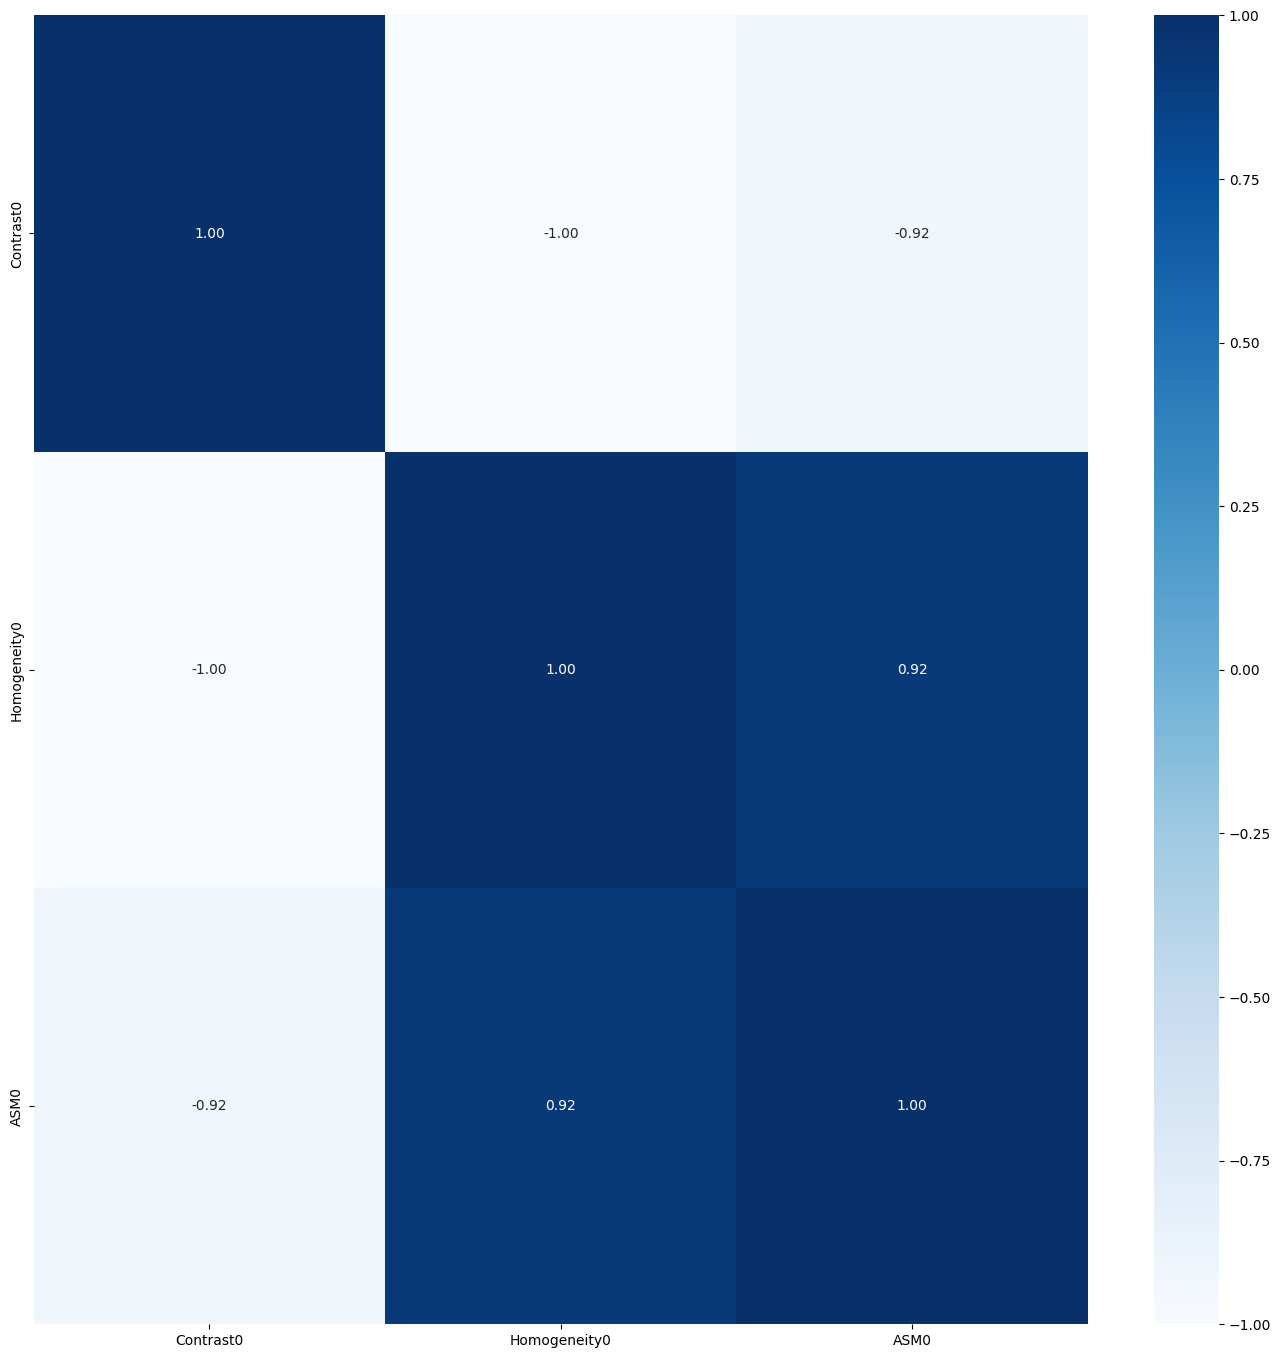

In [17]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [18]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(240, 3)
(60, 3)


In [19]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [20]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [21]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.90      0.94      0.92        78
            polyps       0.94      0.90      0.92        84
ulcerative-colitis       0.92      0.92      0.92        78

          accuracy                           0.92       240
         macro avg       0.92      0.92      0.92       240
      weighted avg       0.92      0.92      0.92       240

[[73  2  3]
 [ 5 76  3]
 [ 3  3 72]]
Accuracy: 0.9208333333333333

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.44      0.32      0.37        22
            polyps       0.43      0.62      0.51        16
ulcerative-colitis       0.57      0.55      0.56        22

          accuracy                           0.48        60
         macro avg       0.48      0.50      0.48        60
      weighted avg       0.49      0.48      0.48        60

[[ 7  7  8]
 [ 5 10  1]
 [ 4  6 12]]
A

In [22]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       1.00      0.18      0.30        78
            polyps       0.49      0.82      0.61        84
ulcerative-colitis       0.60      0.64      0.62        78

          accuracy                           0.55       240
         macro avg       0.69      0.55      0.51       240
      weighted avg       0.69      0.55      0.51       240

[[14 45 19]
 [ 0 69 15]
 [ 0 28 50]]
Accuracy: 0.5541666666666667

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.75      0.14      0.23        22
            polyps       0.48      0.88      0.62        16
ulcerative-colitis       0.52      0.64      0.57        22

          accuracy                           0.52        60
         macro avg       0.58      0.55      0.47        60
      weighted avg       0.59      0.52      0.46        60

[[ 3  8 11]
 [ 0 14  2]
 [ 1  7 14]]


In [23]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                    precision    recall  f1-score   support

      normal-cecum       0.62      0.68      0.65        78
            polyps       0.66      0.73      0.69        84
ulcerative-colitis       0.73      0.58      0.64        78

          accuracy                           0.66       240
         macro avg       0.67      0.66      0.66       240
      weighted avg       0.67      0.66      0.66       240

[[53 15 10]
 [16 61  7]
 [16 17 45]]
Accuracy: 0.6625

------Testing Set------
                    precision    recall  f1-score   support

      normal-cecum       0.39      0.41      0.40        22
            polyps       0.36      0.50      0.42        16
ulcerative-colitis       0.60      0.41      0.49        22

          accuracy                           0.43        60
         macro avg       0.45      0.44      0.44        60
      weighted avg       0.46      0.43      0.44        60

[[9 8 5]
 [7 8 1]
 [7 6 9]]
Accuracy: 0.433333333

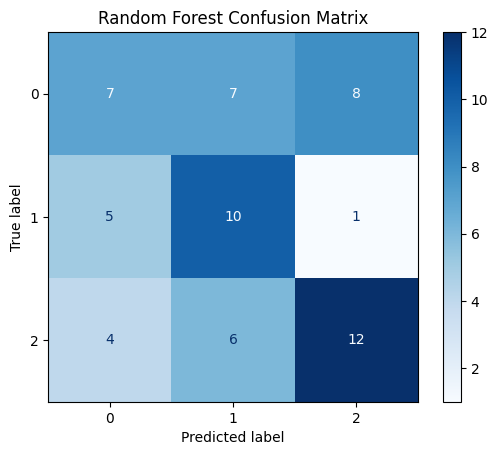

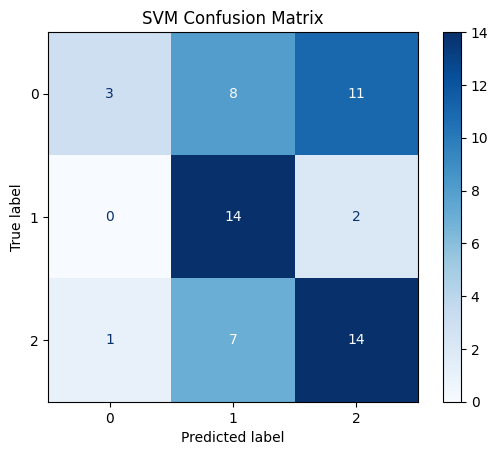

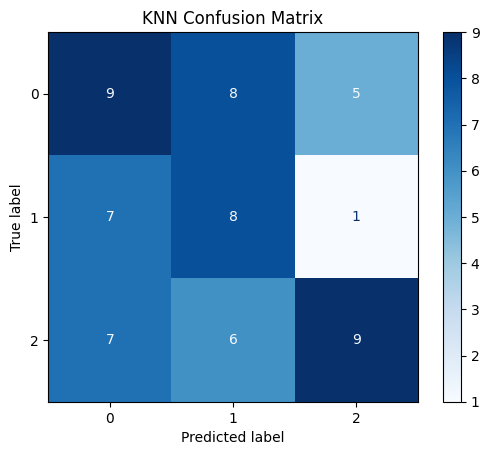

In [24]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")